# Street Sweeper World Lab

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ericmanley/ai_map_environments/blob/main/notebooks/street_sweeper_demo.ipynb)

This notebook demonstrates how to make an AI agent which interacts with a simulated street network environment to clean streets. It's like the Vacuum World example in the Russell-Norvig text, but on a real-world street map.

First, let's install a `mapbots` module that I wrote just for this expercise. It uses the [OSMnx](https://osmnx.readthedocs.io/en/stable/) library to retrieve map data from [OpenStreetMap](https://www.openstreetmap.org).

In [1]:
import sys

!{sys.executable} -m pip install git+https://github.com/ericmanley/ai_map_environments.git

  Cloning https://github.com/ericmanley/ai_map_environments.git to /tmp/pip-req-build-ew5b6x1z
  Running command git clone --filter=blob:none --quiet https://github.com/ericmanley/ai_map_environments.git /tmp/pip-req-build-ew5b6x1z
  Resolved https://github.com/ericmanley/ai_map_environments.git to commit dd6ba40e4da0778dc83533f687e02cab885bb3af
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 3.9 MB/s eta 0:00:00
  Created wheel for mapbots: filename=mapbots-0.1.8-py3-none-any.whl size=9988 sha256=ec992a7673154efef33f418023856cb0f22f198880728cf91a886ca444e5cd70
  Stored in directory: /tmp/pip-ephem-wheel-cache-5jpf4evd/wheels/0b/50/53/36ac44d0f516a21f287937590a805327537725780f4856a8ae
Successfully built mapbots


## Getting started

First, let's import the `StreetSweeperWorld` class, which will be used to simulate the bot's environment and keep track of some important stats about your bot.

We start by creating a `desmoines_bot` object and displaying the map.

Setting up the map. This may take a few minutes.


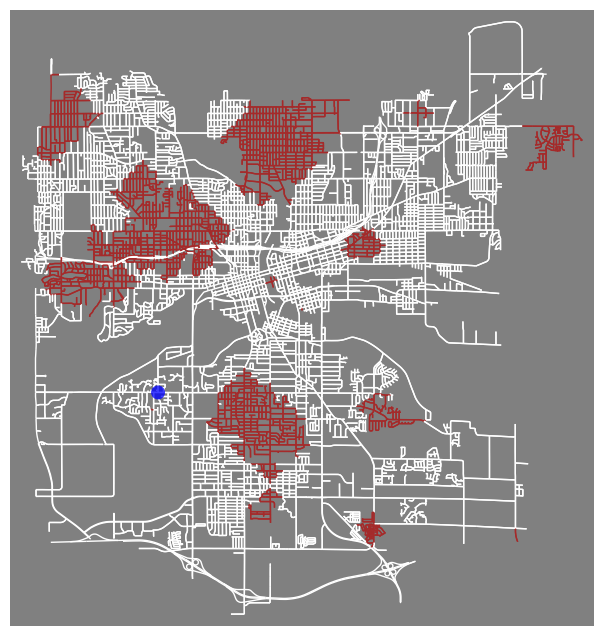

In [2]:
from mapbots import StreetSweeperWorld

desmoines_bot = StreetSweeperWorld(place="Des Moines, Iowa, USA")
desmoines_bot.display_map()

If you don't specify a place, this will just use Des Moines by default. You can try other places, though I have not thoroughly tested how well this exercise works in other locations.

The white lines represent **clean streets**, and the red lines represnt **dirty streets**. The bots task is to clean the dirty streets. The map is for you, the user, to see what's going on - the bot (shown as a blue dot) can't see the whole map.

By default, the dirty regions will be randomly generated. If you want to use the same map more than once (so you can try different ideas on the same map), then specify a `map_number`, which will seed the random number generator so it always generates the map in the same way.

Setting up the map. This may take a few minutes.


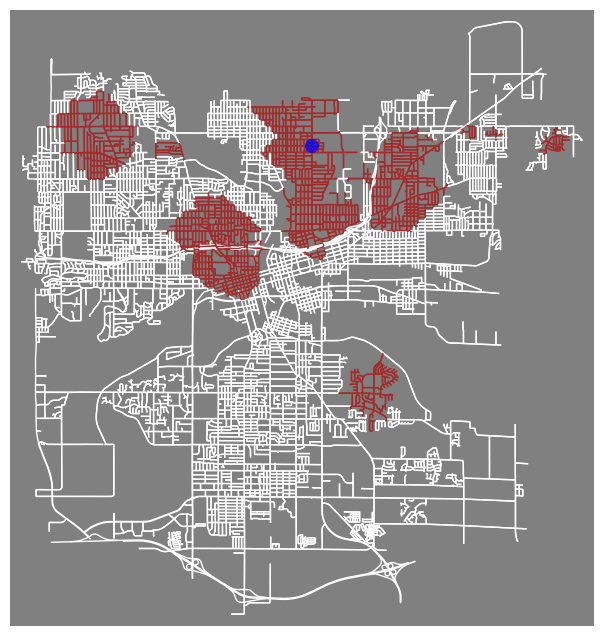

In [46]:
desmoines_bot = StreetSweeperWorld(place="Des Moines, Iowa, USA",map_number=4)
desmoines_bot.display_map()

## What can the bot perceive?

The bot can get some information by calling these methods.

**Battery Life:** The bot starts with 72000 battery life - this roughly represents the number of seconds (20 hours) that the bot could move if it was driving around and not doing any cleaning. As the bot performs actions, the battery life will decrease.

**Meters Cleaned:** This shows the total length of streets that the bot has successfully cleaned - initially it's 0 because it hasn't done any cleaning yet. OSMnx uses meters by default, so that's what we'll go with.

**Bot's Location:** The bot can get some info about its location, which is always an intersection between two or more sections of streets or the end of a street section (the bot can only stop and look this info up when it is at these intersections). The `x` and `y` values are the latitude and longitude of the locations, and the `location_id` is a unique identifier for this location within OSM.

In [47]:
curr_battery = desmoines_bot.get_battery_life()
print("Current life battery remaining:",curr_battery)

curr_amount_cleaned = desmoines_bot.get_meters_cleaned()
print("We have cleaned",curr_amount_cleaned,"meters so far")

curr_loc_data = desmoines_bot.get_current_location()
print("Current location data:",curr_loc_data)

Current life battery remaining: 72000
We have cleaned 0 meters so far
Current location data: {'y': 41.6240966, 'x': -93.6005426, 'street_count': 4, 'location_id': 160868161}


Note that the location data is a dictionary, so you could access specific parts of it like this:

In [48]:
print("Here's the location id of the location where the bot is:",curr_loc_data["location_id"])

Here's the location id of the location where the bot is: 160868161


The bot can also see information about what streets it could move to next from its current location. In this case, there are three streets given in a list. Each street has lots of useful information

**start:** this is the endpoint of the street section you're on - it's the same info that you'd get from `get_current_location()`

**end:** this is the info about the other endpoint of the street - it's the location you'd be in if you followed this section of street.

**street_data:** useful data about the section of street. Some examples are
* **name:** the street's name in real life
* **length:** how long the street is (in meters)
* **speed_kph:** how fast you can drive on this street (in kilometers per hour)
* **travel_time:** how long it takes a car (or your bot) to traverse this section of the street
* **cleanliness:** this is either *clean* or *dirty* - your bot will be interested in this

In [49]:
curr_streets = desmoines_bot.scan_next_streets()
display(curr_streets) #inside notebooks, you can use display instead of print
#print(curr_streets)

[{'start': {'y': 41.6240966,
   'x': -93.6005426,
   'street_count': 4,
   'location_id': 160868161},
  'end': {'y': 41.624112,
   'x': -93.598233,
   'street_count': 3,
   'location_id': 160872222},
  'street_data': {'osmid': 16008736,
   'highway': 'residential',
   'name': 'East Tiffin Avenue',
   'oneway': False,
   'reversed': False,
   'length': 192.07048780418882,
   'geometry': <LINESTRING (-93.601 41.624, -93.6 41.624, -93.598 41.624)>,
   'speed_kph': 41.22691975308642,
   'travel_time': 16.77189953157523,
   'cleanliness': 'dirty'}},
 {'start': {'y': 41.6240966,
   'x': -93.6005426,
   'street_count': 4,
   'location_id': 160868161},
  'end': {'y': 41.624078,
   'x': -93.602221,
   'street_count': 4,
   'location_id': 160908225},
  'street_data': {'osmid': 16008736,
   'highway': 'residential',
   'name': 'East Tiffin Avenue',
   'oneway': False,
   'reversed': True,
   'length': 139.62707576522507,
   'geometry': <LINESTRING (-93.601 41.624, -93.601 41.624, -93.601 41.624, 

since this is a list, if you just wanted to grab one item from the list, you could use a subscript like this:

In [50]:
one_of_the_streets = curr_streets[0]
display(one_of_the_streets)

{'start': {'y': 41.6240966,
  'x': -93.6005426,
  'street_count': 4,
  'location_id': 160868161},
 'end': {'y': 41.624112,
  'x': -93.598233,
  'street_count': 3,
  'location_id': 160872222},
 'street_data': {'osmid': 16008736,
  'highway': 'residential',
  'name': 'East Tiffin Avenue',
  'oneway': False,
  'reversed': False,
  'length': 192.07048780418882,
  'geometry': <LINESTRING (-93.601 41.624, -93.6 41.624, -93.598 41.624)>,
  'speed_kph': 41.22691975308642,
  'travel_time': 16.77189953157523,
  'cleanliness': 'dirty'}}

and if you wanted to grab the location id of the **end** of this section from the first item in the list, you could do it like this:

In [51]:
id_to_move_to = curr_streets[0]["end"]["location_id"]
print(id_to_move_to)

160872222


## What actions can the bot take?

One action the bot can make is to move to an adjacent location. We could take the id we obtained above and pass it to the `move_to` method like this. It returns the id of our new location.

In [52]:
desmoines_bot.move_to(id_to_move_to)

160872222

We can then scan for more streets, and you'll notice they're different!

In [53]:
curr_streets = desmoines_bot.scan_next_streets()
display(curr_streets)

[{'start': {'y': 41.624112,
   'x': -93.598233,
   'street_count': 3,
   'location_id': 160872222},
  'end': {'y': 41.623195,
   'x': -93.598234,
   'street_count': 4,
   'location_id': 160872219},
  'street_data': {'osmid': 16005600,
   'highway': 'residential',
   'name': 'East 15th Street',
   'oneway': False,
   'reversed': True,
   'length': 101.96592565382917,
   'speed_kph': 41.22691975308642,
   'travel_time': 8.903826299715348,
   'cleanliness': 'dirty'}},
 {'start': {'y': 41.624112,
   'x': -93.598233,
   'street_count': 3,
   'location_id': 160872222},
  'end': {'y': 41.624112,
   'x': -93.597963,
   'street_count': 3,
   'location_id': 160872128},
  'street_data': {'osmid': 16008736,
   'highway': 'residential',
   'name': 'East Tiffin Avenue',
   'oneway': False,
   'reversed': False,
   'length': 22.44250684588839,
   'speed_kph': 41.22691975308642,
   'travel_time': 1.9597152814005634,
   'cleanliness': 'dirty'}},
 {'start': {'y': 41.624112,
   'x': -93.598233,
   'stree

In this case, notice that the second street in the list has `"dirty"` as its `"cleanliness"` value. If we want to follow that street **and clean it** then we call the `clean_and_move_to` method like this:

In [54]:
id_to_move_to_and_clean = curr_streets[1]["end"]["location_id"]
desmoines_bot.clean_and_move_to(id_to_move_to_and_clean)

160872128

Notice that the bot's battery has decreased, and it has recorded that it has done some cleaning.

In [55]:
curr_battery = desmoines_bot.get_battery_life()
print("Current life battery remaining:",curr_battery)

curr_amount_cleaned = desmoines_bot.get_meters_cleaned()
print("We have cleaned",curr_amount_cleaned,"meters so far")

curr_loc_data = desmoines_bot.get_current_location()
print("Current location data:",curr_loc_data)

Current life battery remaining: 71977.34895462422
We have cleaned 22.44250684588839 meters so far
Current location data: {'y': 41.624112, 'x': -93.597963, 'street_count': 3, 'location_id': 160872128}


### Battery Rules

The amount of battery your bot uses is equal to the `"travel_time"` of any street it moves over with a `move_to`. If you do a `clean_and_move_to`, it takes three times as much battery power as a `move_to`.

Since the `clean_and_move_to` we did was over a street with 9.8 travel time, it took 9.8*3=29.4 power. The travel time of the first `move_to` was 10.2, so the total battery power used was 10.2+29.4 = 39.6

If you display the map again, you will also notice that the blue dot has moved, leaving a semi-transparent blue path behind it showing where the bot has been.

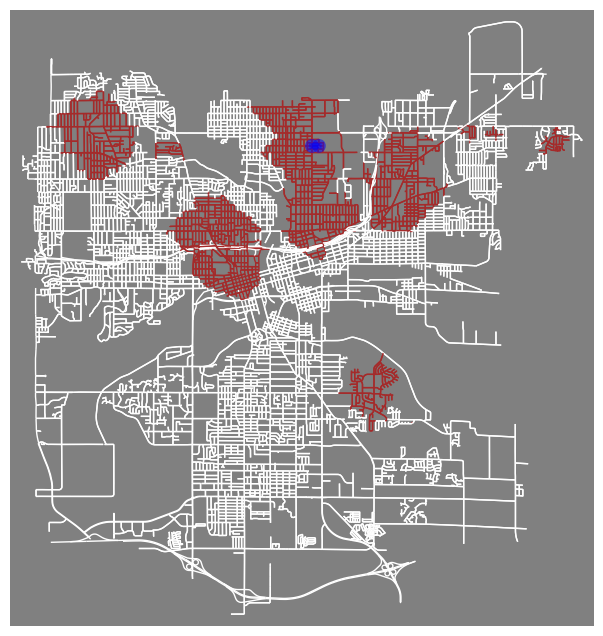

In [56]:
desmoines_bot.display_map()

## Making a bot

One very simple bot could work like this. It just keeps going until the battery is dead. At each point, it scans streets for the next move, chooses one at random, and then cleans that randomly selected street.

As is, this results in an error because it is possible to get stuck in one-way dead-ends, which is probably just an error in the map data.

In [57]:
import random

while desmoines_bot.get_battery_life() > 0:

    move_options = desmoines_bot.scan_next_streets()
    chosen_street = random.choice(move_options)
    desmoines_bot.clean_and_move_to(chosen_street["end"]["location_id"])

print("Final location:",desmoines_bot.get_current_location())
print("Final battery life:",desmoines_bot.get_battery_life())
print("Total distance cleaned (meters):",desmoines_bot.get_meters_cleaned())
desmoines_bot.display_map()

IndexError: Cannot choose from an empty sequence

To help you get out of this, there is a `backup` method that we can call if there are no move options. You can specificy how many levels you want to back out. Backing up doesn't use up any of your battery power (though you did use battery getting stuck in the first place).

Final location: {'y': 41.5918337, 'x': -93.7044277, 'street_count': 3, 'location_id': 391152491}
Final battery life: -28.29514861553698
Total distance cleaned (meters): 60455.80609783351


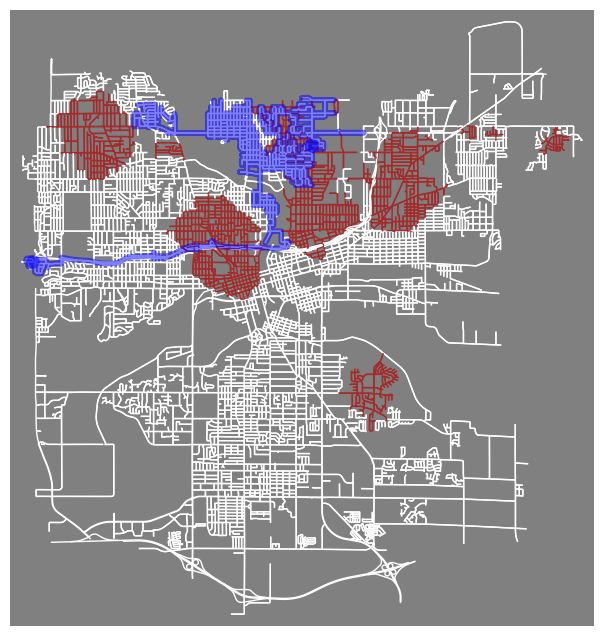

In [58]:
import random

while desmoines_bot.get_battery_life() > 0:

    move_options = desmoines_bot.scan_next_streets()
    if move_options == []:
        desmoines_bot.backup(how_many=5)
    else:
        chosen_street = random.choice(move_options)
        desmoines_bot.clean_and_move_to(chosen_street["end"]["location_id"])

print("Final location:",desmoines_bot.get_current_location())
print("Final battery life:",desmoines_bot.get_battery_life())
print("Total distance cleaned (meters):",desmoines_bot.get_meters_cleaned())
desmoines_bot.display_map()

## Making a better bot

This first bot isn't very smart at all - it just cleans indiscriminantly. Since it takes extra power to clean, let's improve it and only cleaning if street is actually dirty.

Setting up the map. This may take a few minutes.


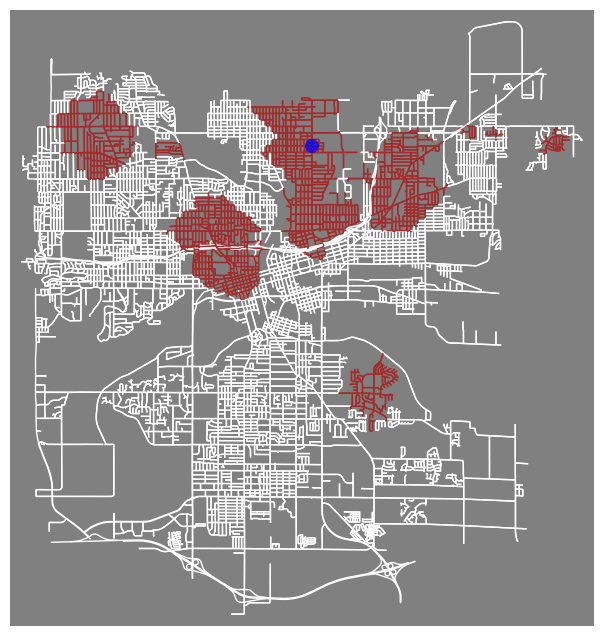

Final location: {'y': 41.61122, 'x': -93.596179, 'street_count': 3, 'location_id': 160869647}
Final battery life: -17.616617861431667
Total distance cleaned (meters): 139821.39794381557


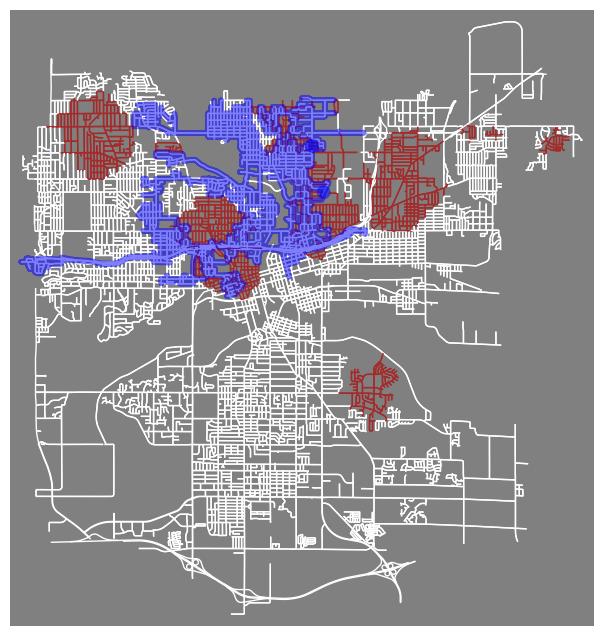

In [59]:
random_bot = StreetSweeperWorld(place="Des Moines, Iowa, USA",map_number=4)
random_bot.display_map()

while random_bot.get_battery_life() > 0:

    move_options = random_bot.scan_next_streets()
    if move_options == []:
        random_bot.backup(how_many=5)
    else:
        chosen_street = random.choice(move_options)

        # a new feature - let's decide whether to clean or just move based
        # on whether the street's cleanliness value is actually dirty
        if chosen_street["street_data"]["cleanliness"] == "dirty":
            random_bot.clean_and_move_to(chosen_street["end"]["location_id"])
        else:
            random_bot.move_to(chosen_street["end"]["location_id"])

print("Final location:",random_bot.get_current_location())
print("Final battery life:",random_bot.get_battery_life())
print("Total distance cleaned (meters):",random_bot.get_meters_cleaned())
random_bot.display_map()

this seems to have improved the total distance cleaned since it was able to cover more streets with the saved battery life.

### Exercise:

Try this on some different map numbers and keep track of the difference between these two approaches on average.

### Exercise:

Change the code so that if some of `move_options` are clean and some are dirty, it will select a dirty one. How can you tell whether this approach is better on average?

### Exercise:

Discuss some other ideas for improving your bot's performance with your group, and try implementing some of them.

## Assignment

The agent we designed in this demo are reflex agents - they make decisions based only on what they perceive in this moment. Come up with a strategy for a model-based agent
* this means that you should keep track of something - for example, what locations you have been to or how dirty of an area you seem to be in (e.g., how many dirty streets have you scanned in the last 20 actions?)
* make rational decisions based on the current percepts and the state that you're keeping track of

Implement the idea and test it out. Compare it on at least 10 different map numbers against the best reflex-only agent you tried in this lab. Create a Jupyter Notebook like this one where you run your experiments and display the results. Include a markdown cell (like this one you're reading right now) where you describe your model-based agent's idea. Use headers/sections like this:

### Idea behind my model-based agent

In this section, write how your model-based agent works and *say what it is about it that makes it model-based*. You should also say why this is a reasonable approach - why do you think it *could* be an improvement.

### Results

Here you should describe the results of your experiment and come to a conclusion about which bot idea was best - it's ok if your model-based idea isn't better (or even if it is only a little better) as long as you run a good test showing it.

### Grading

The assignment will be worth 8 points.
* You can get up to 1 point if you turn in the starter notebook and you ran all the code yourself. Create a markdown cell at the top where you explain that's what you did.
* You can get up to 4 points if you turn in the starter notebook and you attempted each of the lab exercises.
* You can get up to 8 points if you implemented a model-based agent, performed an experiment where you compared it against one of the reflex-only agents, and wrote-up your description and results as directed above. Partial credit (5-7 points) will be given if any of these parts are incomplete.

### Turning it in

You should submit your Jupyter Notebook to the handin form on Blackboard. You can either submit a link to a shared version of your notebook from Google Colab (make it sharable so that anyone with the link can view it) or you can directly attach the .ipynb file to the handin form.